# Linear Regression, GRLR (Geodesic Regression Linear Residuals), GR on the sphere

In [72]:
import setcwd

setcwd.main()
import os
import time

import matplotlib.pyplot as plt
import torch
from sklearn.linear_model import LinearRegression

from my28brains.regression.geodesic_regression import GeodesicRegression

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.hyperbolic import Hyperbolic
from geomstats.learning.frechet_mean import FrechetMean, variance

torch_dtype = torch.float64

Working directory:  /home/adele/code/my28brains/my28brains
Directory added to path:  /home/adele/code/my28brains
Directory added to path:  /home/adele/code/my28brains/my28brains
Directory added to path:  /home/adele/code/my28brains/H2_SurfaceMatch


In [73]:
space = Hypersphere(dim=2)
space.__class__.__name__

'Hypersphere'

In [108]:
viz_dict = {
    "Hypersphere" : visualization.Sphere(n_meridians=30),
    "PoincareBall" : visualization.PoincareDisk(), #note: this did not work. points that belonged to poincare ball did not belong to H2
    "Hyperboloid": visualization.PoincareDisk()
}

# Set up experiment

In [166]:
n_samples = 50
noise_std = 2
# space = Hypersphere(dim=2) 
space = Hyperbolic(dim=2, default_coords_type="extrinsic")
space.__class__.__name__


# space = Hyperbolic(dim=2, default_coords_type="ball")

'Hyperboloid'

# Generate data

### Necessary functions missing from PoincareBall in geomstats
Pretty much copied from Hypersphere in geomstats... hopefully that is ok.

Key change: The embedding space of the poincare ball is the same dimension as its embedding space, and the embedding space of the hypersphere is one dimension higher than the hypersphere.

--> to combat this: in random_uniform, I replace space.dim + 1 (used by hypersphere) with space.dim. because I am assuming space.dim + 1 (used by hypersphere) is referring to the space of the embedding space, but for the poincare ball, that is space.dim.

In [167]:
def generate_poincare_ball_data(space, n_samples=50, noise_std=1.0):
    gs.random.seed(0)

    #X needs to be the dimension of the embedding space, which is 2.
    X = gs.random.rand(n_samples)
    X -= gs.mean(X)

    random_2d_point = gs.array([gs.random.rand(space.dim)])
    another_random_2d_point = gs.array([gs.random.rand(space.dim)])

    intercept = space.projection(random_2d_point)
    print(f'intercept shape {intercept.shape}')
    coef = space.metric.log(point = another_random_2d_point, base_point = intercept)
    print(f'coef shape {coef.shape}')
    y = space.metric.exp(X[:, None] * coef, base_point=intercept)

    # # Generate normal noise
    # normal_noise = gs.random.normal(
    #     size=(n_samples, space.embedding_space.dim), scale=noise_std
    # )
    # noise = to_tangent(space, normal_noise, base_point=y) / gs.pi / 2

    # rss = gs.sum(space.metric.squared_norm(noise, base_point=y)) / n_samples

    # # Add noise
    # y = space.metric.exp(noise, y)

    rss = 1
    
    
    return X, y, intercept, coef, rss

In [168]:
def generate_hyperboloid_data(space, n_samples=50, noise_std=1.0):
    # Note: hyperboloid embedded in 3d euclidean space
    gs.random.seed(0)

    #X needs to be the dimension of the embedding space, which is 2.
    X = gs.random.rand(n_samples)
    X -= gs.mean(X)

    random_3d_point = gs.array([gs.random.rand(space.dim+1)])
    another_random_3d_point = gs.array([gs.random.rand(space.dim+1)])

    intercept = space.projection(random_3d_point)
    print(f'intercept shape {intercept.shape}')
    coef = space.metric.log(point = another_random_3d_point, base_point = intercept)
    print(f'coef shape {coef.shape}')
    y = space.metric.exp(X[:, None] * coef, base_point=intercept)

    # # Generate normal noise
    # normal_noise = gs.random.normal(
    #     size=(n_samples, space.embedding_space.dim), scale=noise_std
    # )
    # noise = to_tangent(space, normal_noise, base_point=y) / gs.pi / 2

    # rss = gs.sum(space.metric.squared_norm(noise, base_point=y)) / n_samples

    # # Add noise
    # y = space.metric.exp(noise, y)

    rss = 1
    
    
    return X, y, intercept, coef, rss

### Actually Generate Data

In [169]:
# Generate noise-free data


def generate_data(space, n_samples=50, noise_std=1.0):
    gs.random.seed(0)

    X = gs.random.rand(n_samples)
    X -= gs.mean(X)

    space_name = space.__class__.__name__
    if space_name == 'Hypersphere':
        intercept = space.random_uniform()
        print(f'intercept shape {intercept.shape}')
        vector = 5.0 * gs.random.rand(space.embedding_space.dim)
        print(f'vector_shape {vector.shape}')
        print(f'embedding space dim {space.embedding_space.dim}')
        coef = space.to_tangent(
            5.0 * gs.random.rand(space.embedding_space.dim), base_point=intercept
        )
        y = space.metric.exp(X[:, None] * coef, base_point=intercept)
    
        # Generate normal noise
        normal_noise = gs.random.normal(
            size=(n_samples, space.embedding_space.dim), scale=noise_std
        )
        noise = space.to_tangent(normal_noise, base_point=y) / gs.pi / 2
    
        rss = gs.sum(space.metric.squared_norm(noise, base_point=y)) / n_samples
    
        # Add noise
        y = space.metric.exp(noise, y)

        return X, y, intercept, coef, rss
    elif space_name == 'PoincareBall':
        return generate_poincare_ball_data(space, n_samples, noise_std)
    elif space_name == "Hyperboloid":
        return generate_hyperboloid_data(space, n_samples, noise_std)

In [170]:
X, y, intercept, coef, rss = generate_data(space, n_samples=n_samples, noise_std=noise_std)

intercept shape torch.Size([1, 3])
coef shape torch.Size([1, 3])


### Test to see whether generated data is on the poincare ball

In [171]:
space.belongs(y)

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True])

# Run Regression

### add visualization capability for poincare ball

In [172]:
def fit_linear_regression(
    space, X, y, intercept=None, coef=None
):  # , device = "cuda:0"):
    """Perform linear regression.

    Parameters
    ----------


    Returns
    -------
    intercept_hat: intercept of regression fit
    coef_hat: slope of regression fit
    """
    X_copy = gs.array(X.reshape(len(X), 1))

    start_time = time.time()
    lr = LinearRegression()

    lr.fit(X_copy, y)

    intercept_hat, coef_hat = gs.array(lr.intercept_), gs.array(lr.coef_)

    duration_time = time.time() - start_time

    # Measure goodness of fit
    r2_hat = lr.score(X_copy, y)

    # Calculate MSE
    mse_intercept = gs.linalg.norm(intercept_hat - intercept) ** 2
    mse_coef = gs.linalg.norm(coef_hat - coef) ** 2

    print(f"MSE on the intercept: {mse_intercept:.2e}")
    print(f"MSE on the coef, i.e. initial velocity: {mse_coef:.2e}")
    print(f"Determination coefficient: R^2={r2_hat:.2f}")
    # print(f"True R^2: {r2:.2f}")

    # Plot
    fitted_data = gs.array(lr.predict(X_copy))
    fig = plt.figure(figsize=(8, 8))

    assert space.dim == 2, "space's dimension is not 2 -> can't visualize!"
    manifold_visu = viz_dict[space.__class__.__name__]

    size = 10
    marker = "o"

    if space.__class__.__name__ == "Hypersphere":
        ax = fig.add_subplot(111, projection="3d")
        ax = manifold_visu.set_ax(ax=ax)
        manifold_visu.draw_points(ax, gs.array([intercept_hat]), marker=marker, c="r", s=size)
        manifold_visu.draw_points(ax, y, marker=marker, c="b", s=size)
        manifold_visu.draw_points(ax, fitted_data, marker=marker, c="g", s=size)
        manifold_visu.draw(ax, linewidth=1)
    elif space.__class__.__name__ == "PoincareBall":
        raise "PoincareBall not implemented"
        ax = fig.add_subplot(111)
        ax = manifold_visu.set_ax(ax=ax)
        projected_intercept_hat = space.projection(intercept_hat)
        projected_fitted_data = space.projection(fitted_data)
        manifold_visu.plot(gs.array([projected_intercept_hat]),ax = ax, marker=marker, c="r", s=size)
        manifold_visu.plot(y, ax = ax, marker=marker, c="b", s=size)
        manifold_visu.plot(projected_fitted_data, ax = ax, marker=marker, c="g", s=size)
        
    elif space.__class__.__name__ == "Hyperboloid":
        ax = fig.add_subplot(111)
        ax = manifold_visu.set_ax(ax=ax)
        projected_intercept_hat = space.projection(intercept_hat)
        projected_fitted_data = space.projection(fitted_data)
        manifold_visu.plot(gs.array([projected_intercept_hat]),ax = ax, marker=marker, c="r", s=size)
        manifold_visu.plot(y, ax = ax, marker=marker, c="b", s=size)
        manifold_visu.plot(projected_fitted_data, ax = ax, marker=marker, c="g", s=size)

    ax.grid(False)
    plt.axis("off")
    plt.show()

    return intercept_hat, coef_hat, lr, duration_time

MSE on the intercept: 1.07e-03
MSE on the coef, i.e. initial velocity: 2.59e+00
Determination coefficient: R^2=0.93


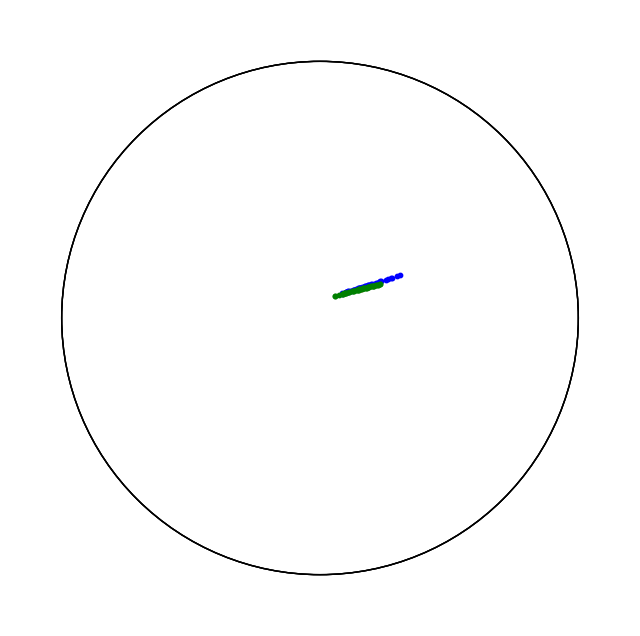

lr_duration_time: 0.0014269351959228516
coef_hat.shape: torch.Size([3])


In [173]:
intercept_hat, coef_hat, lr, lr_duration_time = fit_linear_regression(
    space=space, X=X, y=y, intercept=intercept, coef=coef
)

coef_hat = coef_hat.reshape(intercept_hat.shape)

print(f"lr_duration_time: {lr_duration_time}")
print(f"coef_hat.shape: {coef_hat.shape}")

In [174]:
def fit_geodesic_regression(
    space,
    X,
    y,
    intercept,
    coef,
    rss,
    linear_residuals=False,
    gr_initialization="warm_start",
    intercept_hat_guess=None,
    coef_hat_guess=None,
    
):
    r"""Compute and visualize a geodesic regression on the sphere.

    The generative model of the data is:
    :math:`Z = Exp_{\beta_0}(\beta_1.X)` and :math:`Y = Exp_Z(\epsilon)`
    where:
    - :math:`Exp` denotes the Riemannian exponential,
    - :math:`\beta_0` is called the intercept,
    - :math:`\beta_1` is called the coefficient,
    - :math:`\epsilon \sim N(0, 1)` is a standard Gaussian noise,
    - :math:`X` is the input, :math:`Y` is the target.

    TODO: when we start testing on more spaces, have "space" as
    an input so that this function is more general.

    TODO: generate data OUTSIDE of this function -
    that way you are SURE that the data is same for each run
    AND it takes less time for each run to finish.
    """
    # True noise level and R2
    estimator = FrechetMean(space)  # .metric)
    estimator.fit(y)
    variance_ = variance(space, y, estimator.estimate_)
    r2 = 1 - rss / variance_

    start_time = time.time()

    # Fit geodesic regression
    gr = GeodesicRegression(
        space,
        # center_X=False,
        method="extrinsic",
        # initialization = 'warm_start',
        verbose=True,
        initialization=gr_initialization,
        # tol=0.0000005,  # TODO: this might depend on the type of data we have.
        linear_residuals=linear_residuals,
        compute_training_score=False,
    )

    if gr_initialization == "warm_start":
        if intercept_hat_guess is None:
            intercept_hat_guess = gs.array(y[0])
        elif intercept_hat_guess.shape != y[0].shape:
            raise ValueError(
                "intercept_hat_guess must be None or have mesh_sequence[0].shape"
            )

        if coef_hat_guess is None:
            coef_hat_guess = gs.array(y[1] - y[0])

        gr.intercept_ = intercept_hat_guess
        gr.coef_ = coef_hat_guess

    gr.fit(gs.array(X), gs.array(y))
    intercept_hat, coef_hat = gr.intercept_, gr.coef_

    duration_time = time.time() - start_time

    # # Measure Mean Squared Error
    mse_intercept = space.metric.squared_dist(intercept_hat, intercept)

    tangent_vec_to_transport = coef_hat
    tangent_vec_of_transport = space.metric.log(intercept, base_point=intercept_hat)
    transported_coef_hat = space.metric.parallel_transport(
        tangent_vec=tangent_vec_to_transport,
        base_point=intercept_hat,
        direction=tangent_vec_of_transport,
    )
    mse_coef = space.metric.squared_norm(
        transported_coef_hat - coef, base_point=intercept
    )

    # Measure goodness of fit
    r2_hat = gr.training_score_

    # print(f"MSE on the intercept: {mse_intercept:.2e}")
    # print(f"MSE on the coef, i.e. initial velocity: {mse_coef:.2e}")
    # print(f"Determination coefficient: R^2={r2_hat:.2f}")
    # print(f"True R^2: {r2:.2f}")

    # Plot

    space_name = space.__class__.__name__
    if space_name == "Hypersphere":
        fitted_data = gr.predict(X)
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection="3d")
        manifold_visu = visualization.Sphere(n_meridians=30)
        ax = manifold_visu.set_ax(ax=ax)
    
        path = space.metric.geodesic(
            initial_point=intercept_hat, initial_tangent_vec=coef_hat
        )
        regressed_geodesic = path(
            gs.linspace(0.0, 1.0, 100) * gs.pi * 2 / space.metric.norm(coef)
        )
        regressed_geodesic = gs.to_numpy(regressed_geodesic)
    
        size = 10
        marker = "o"
        manifold_visu.draw_points(ax, gs.array([intercept_hat]), marker=marker, c="r", s=size)
        manifold_visu.draw_points(ax, y, marker=marker, c="b", s=size)
        manifold_visu.draw_points(ax, fitted_data, marker=marker, c="g", s=size)
    
        ax.plot(
            regressed_geodesic[:, 0],
            regressed_geodesic[:, 1],
            regressed_geodesic[:, 2],
            c="gray",
        )
        manifold_visu.draw(ax, linewidth=1)
    elif space_name == "Hyperboloid":
        

    ax.grid(False)
    plt.axis("off")

    plt.show()

    return fitted_data, duration_time

Optimization terminated successfully.
         Current function value: 0.015864
         Iterations: 14
         Function evaluations: 196
         Gradient evaluations: 28


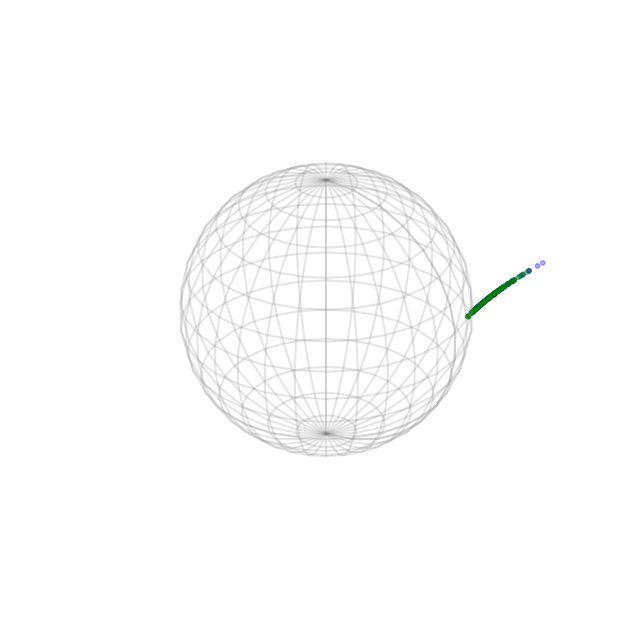

gr_duration_time: 0.35468053817749023


In [175]:
fitted_data_geodesic_residuals, gr_duration_time = fit_geodesic_regression(
    space=space,
    X=X,
    y=y,
    intercept=intercept,
    coef=coef,
    rss=rss,
    linear_residuals=False,
    # gr_initialization="warm_start",
    # intercept_hat_guess=intercept_hat,
    # coef_hat_guess=coef_hat,
)

print(f"gr_duration_time: {gr_duration_time}")

Optimization terminated successfully.
         Current function value: 4.147333
         Iterations: 17
         Function evaluations: 231
         Gradient evaluations: 33


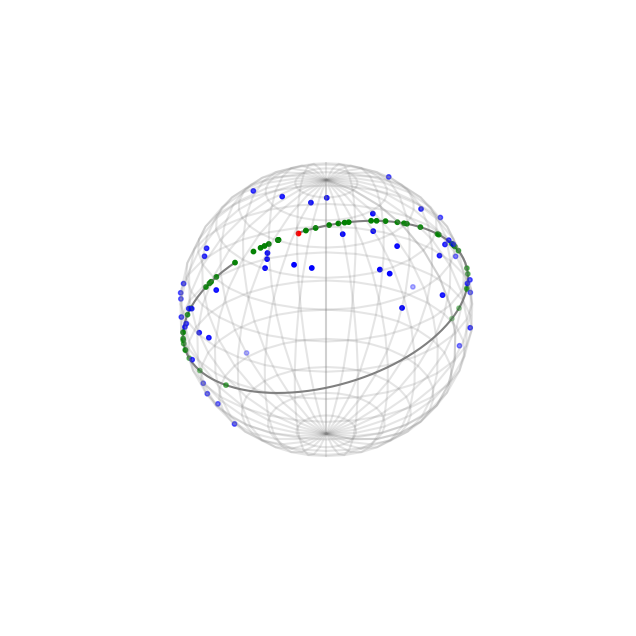

grlr_duration_time: 0.1690196990966797


In [11]:
fitted_data_linear_residuals, grlr_duration_time = fit_geodesic_regression(
    space=space,
    X=X,
    y=y,
    intercept=intercept,
    coef=coef,
    rss=rss,
    linear_residuals=True,
    gr_initialization="warm_start",
    intercept_hat_guess=intercept_hat,
    coef_hat_guess=coef_hat,
)

print(f"grlr_duration_time: {grlr_duration_time}")

In [12]:
print(fitted_data_geodesic_residuals - fitted_data_linear_residuals)

print(gr_duration_time / grlr_duration_time)

tensor([[-1.5459e-03,  5.6036e-04, -2.8855e-03],
        [-3.4828e-04,  2.6346e-03, -1.8484e-04],
        [-3.5075e-04,  1.1287e-03,  8.7601e-04],
        [-1.2412e-03,  1.2969e-03, -2.5350e-03],
        [-2.8072e-04,  2.4600e-03,  3.9788e-04],
        [-5.7983e-04,  2.4889e-03, -1.1357e-03],
        [ 5.1480e-04, -2.1565e-04, -1.1243e-03],
        [-2.7086e-04,  3.2819e-04,  2.8325e-04],
        [-2.8338e-04,  2.0942e-03,  7.9217e-04],
        [-8.9056e-05,  6.0173e-06, -2.3111e-04],
        [-3.5202e-04,  1.0753e-03,  8.5587e-04],
        [ 5.2763e-04, -2.1570e-04, -1.1368e-03],
        [-2.7888e-04,  3.5399e-04,  3.1436e-04],
        [-2.7503e-04,  2.3457e-03,  5.6673e-04],
        [-3.4264e-04,  1.3146e-03,  9.2731e-04],
        [-3.5283e-04,  9.7730e-04,  8.1257e-04],
        [-3.4243e-04,  7.1518e-04,  6.5409e-04],
        [ 3.3442e-04, -2.0179e-04, -9.2598e-04],
        [-2.9334e-04,  2.5388e-03,  2.3032e-04],
        [-5.5648e-04,  2.5165e-03, -1.0610e-03],
        [ 3.0345e-04

Optimization terminated successfully.
         Current function value: 4.147333
         Iterations: 19
         Function evaluations: 259
         Gradient evaluations: 37


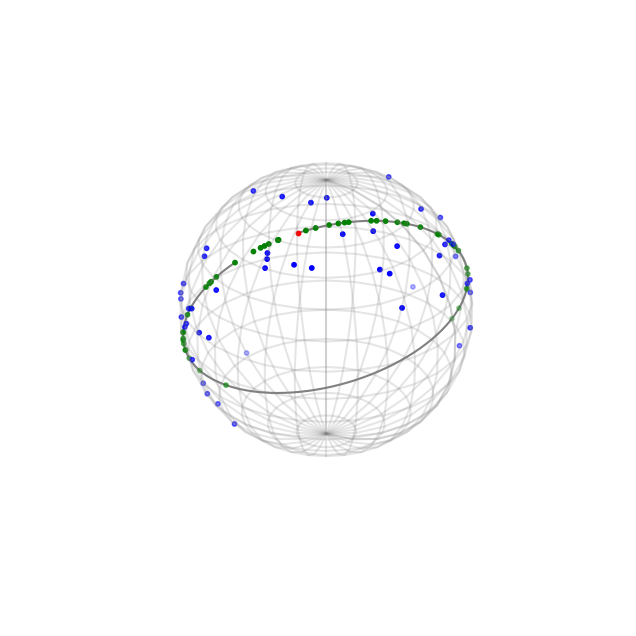

grlr_duration_time: 0.20606231689453125


In [13]:
fitted_data_linear_residuals, grlr_duration_time = fit_geodesic_regression(
    space=space,
    X=X,
    y=y,
    intercept=intercept,
    coef=coef,
    rss=rss,
    linear_residuals=True,
    gr_initialization="frechet",
    intercept_hat_guess=intercept_hat,
    coef_hat_guess=coef_hat,
)

print(f"grlr_duration_time: {grlr_duration_time}")

Optimization terminated successfully.
         Current function value: 4.147333
         Iterations: 24
         Function evaluations: 336
         Gradient evaluations: 48


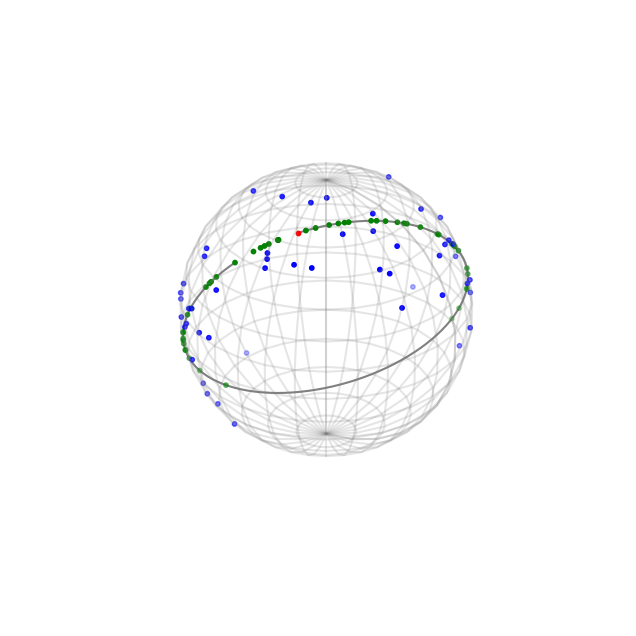

grlr_duration_time: 0.2441565990447998


In [14]:
fitted_data_linear_residuals, grlr_duration_time = fit_geodesic_regression(
    space=space,
    X=X,
    y=y,
    intercept=intercept,
    coef=coef,
    rss=rss,
    linear_residuals=True,
    gr_initialization="random",
    intercept_hat_guess=intercept_hat,
    coef_hat_guess=coef_hat,
)

print(f"grlr_duration_time: {grlr_duration_time}")

Optimization terminated successfully.
         Current function value: 4.147333
         Iterations: 34
         Function evaluations: 413
         Gradient evaluations: 59


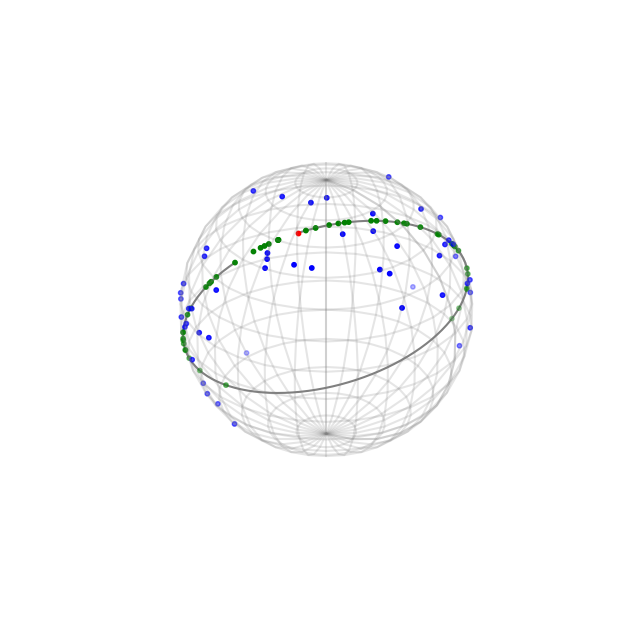

grlr_duration_time: 0.2922985553741455


In [15]:
fitted_data_linear_residuals, grlr_duration_time = fit_geodesic_regression(
    space=space,
    X=X,
    y=y,
    intercept=intercept,
    coef=coef,
    rss=rss,
    linear_residuals=True,
    gr_initialization="data",
    intercept_hat_guess=intercept_hat,
    coef_hat_guess=coef_hat,
)

print(f"grlr_duration_time: {grlr_duration_time}")

In [ ]:
def poincare_random_uniform(space, n_samples = 1):
    size = (n_samples, space.dim)

    samples = gs.random.normal(size=size)
    while True:
        norms = gs.linalg.norm(samples, axis=1)
        indcs = gs.isclose(norms, 0.0, atol=gs.atol)
        num_bad_samples = gs.sum(indcs)
        if num_bad_samples == 0:
            break
        new_samples = gs.random.normal(size=(num_bad_samples, space.dim))
        samples = space._replace_values(samples, new_samples, indcs)

    samples = gs.einsum("..., ...i->...i", 1 / norms, samples)
    if n_samples == 1:
        samples = gs.squeeze(samples, axis=0)
        

    if space.dim in [1, 2] and space.default_coords_type == "intrinsic":
        return space.extrinsic_to_intrinsic_coords(samples)
    return samples

# Test: creating a tangent vector that is actually on the poincaire disk.

New idea is to generate a point and project it to the space (for the intercept)

and when i need to create a tangent vector, create two points, and then extract a tangent vector by taking the log of the two points.

In [39]:
def generate_poincare_data(space, n_samples=50, noise_std=1.0):
    gs.random.seed(0)

    #X needs to be the dimension of the embedding space, which is 2.
    X = gs.random.rand(n_samples)
    X -= gs.mean(X)

    n_samples = 1
    size = (n_samples, space.dim)

    random_2d_point = gs.array([gs.random.rand(size)])
    another_random_2d_point = gs.array([gs.random.rand(size)])

    intercept = space.projection(random_2d_point)
    print(f'intercept shape {intercept.shape}')
    coef = space.metric.log(point = another_random_2d_point, base_point = intercept)
    print(f'coef shape {coef.shape}')
    y = space.metric.exp(X[:, None] * coef, base_point=intercept)

    # # Generate normal noise
    # normal_noise = gs.random.normal(
    #     size=(n_samples, space.embedding_space.dim), scale=noise_std
    # )
    # noise = to_tangent(space, normal_noise, base_point=y) / gs.pi / 2

    # rss = gs.sum(space.metric.squared_norm(noise, base_point=y)) / n_samples

    # # Add noise
    # y = space.metric.exp(noise, y)
    
    
    return X, y, intercept, coef, rss

In [40]:
X, y, intercept, coef, rss = generate_poincare_data(space, n_samples=n_samples, noise_std=noise_std)
print(y.shape)
print(X.shape)
# https://github.com/geomstats/geomstats/blob/2eeee177044e38080cc1004ae4a0bf8dd9ceb601/examples/plot_geodesics_h2.py

hi
space belongs tensor([[True]])
intercept shape torch.Size([1, 1, 2])
coef shape torch.Size([1, 1, 2])
torch.Size([1, 50, 2])
torch.Size([50])


In [42]:
space.belongs(y)

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True]])